<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_Bagging_Pasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Bagging and Pasting on Moon Dataset

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply Bagging and Pasting ensamble learning to improve learning score

## Load Dataset

In [1]:
from sklearn.datasets import make_moons

from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import Image


In [101]:
# Create dataset
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Split dataset to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Default test size 25% of X

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (375, 2)
y_train shape: (375,)

X_test shape: (125, 2)
y_test shape: (125,)


## Bagging Classifier
Bagging classifier (aka. _bootstrpping_) use sampling with replacement. I need to set the `bootstrp=True` to specify that I want to use sampling with replacement. Unlike the __VotingClassifier__, it only train one type of estimator, but on multiple subsets of the training set.

In [102]:
bag_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=500, # Training 500 different DecisionTreeClassifiers
    max_samples=100, # number of samples to draw from X_train to train each base estimator (with replacement for bagging)
    bootstrap=True, # using Bagging instead of Pasting (sampling with replacement)
    n_jobs=-1, # using all available CPU cores
    oob_score=True, # compute out-of-bag score (for evaluation of the bagging classifier using the remaing 37% of unsampled data)
    random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

### Check Base Estimators
Here are the first two estimators.

In [4]:
bag_clf.estimators_[:2]

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086)]

Let's check the sample subsets used for trainig the first two estimators. Note that the length of each subset is 100 since I set `max_samples=100`.

In [5]:
# List of dynamically generated indices identifying samples used for fitting each member of ensamble
bag_clf.estimators_samples_[:2]

[array([ 41, 332, 130, 231,  92, 199, 370, 120,  28, 233,  84,   6, 324,
        338, 307, 105,  74, 290, 349, 260, 290,   8, 288,  59,  95,   3,
        150, 363, 302, 116, 194, 361,  77, 184, 336, 242, 241, 213,  64,
        256,  59, 103, 337,  41, 347,  70, 132, 256,  60, 279,  14, 234,
        249, 183, 203, 301, 340, 165, 100, 173, 213, 367,  23,  70,   1,
        337, 172, 294, 353, 367, 371,  52,   9, 338, 327, 109,  73, 372,
        217, 196,  14, 288, 104, 299, 104,  45, 357,  53, 261, 370, 146,
         36, 303, 279, 340, 240, 352,  39, 120, 292]),
 array([174, 151, 279,  31, 357, 234,   3, 303, 202,  83, 200, 163, 109,
        355, 104,  72, 274,  71, 249, 346, 117, 219,  51, 314,  75, 250,
         87, 184, 363,  16, 227, 341,  84, 227, 347,   7, 244, 193,  72,
          3, 131, 177, 317,  45,  31, 182, 226,  84, 171, 239, 258, 265,
        178, 313, 315, 119,  39, 184, 334,  53, 189, 139,  87, 193, 113,
         17, 297, 152, 119,  12, 121,  50, 339, 359, 225, 315,  55, 3

I used the following helper function to create a .got object and save .png image of the tree structure. The following cell plot the first two trees side-by-side.

In [6]:
def create_and_save_dot_image(tree_clf, size, filename):
    # Create and export .dot file
    export_graphviz(
            tree_clf,
            out_file= 'file.dot',
            # feature_names=iris.feature_names[2:],
            # class_names=iris.target_names,
            rounded=True,
            filled=True)

    # Read the .dot file into a string
    with open('file.dot', 'r') as file:
        dot_data = file.read()

    # Insert the size attribute into the string
    dot_data = dot_data.replace('digraph Tree {', f'digraph Tree {{\ngraph [size="{size}"];')

    # Create and save a Source object from the modified string
    src = Source(dot_data)
    src.render(filename, format='png')

    return f'{filename}.png'

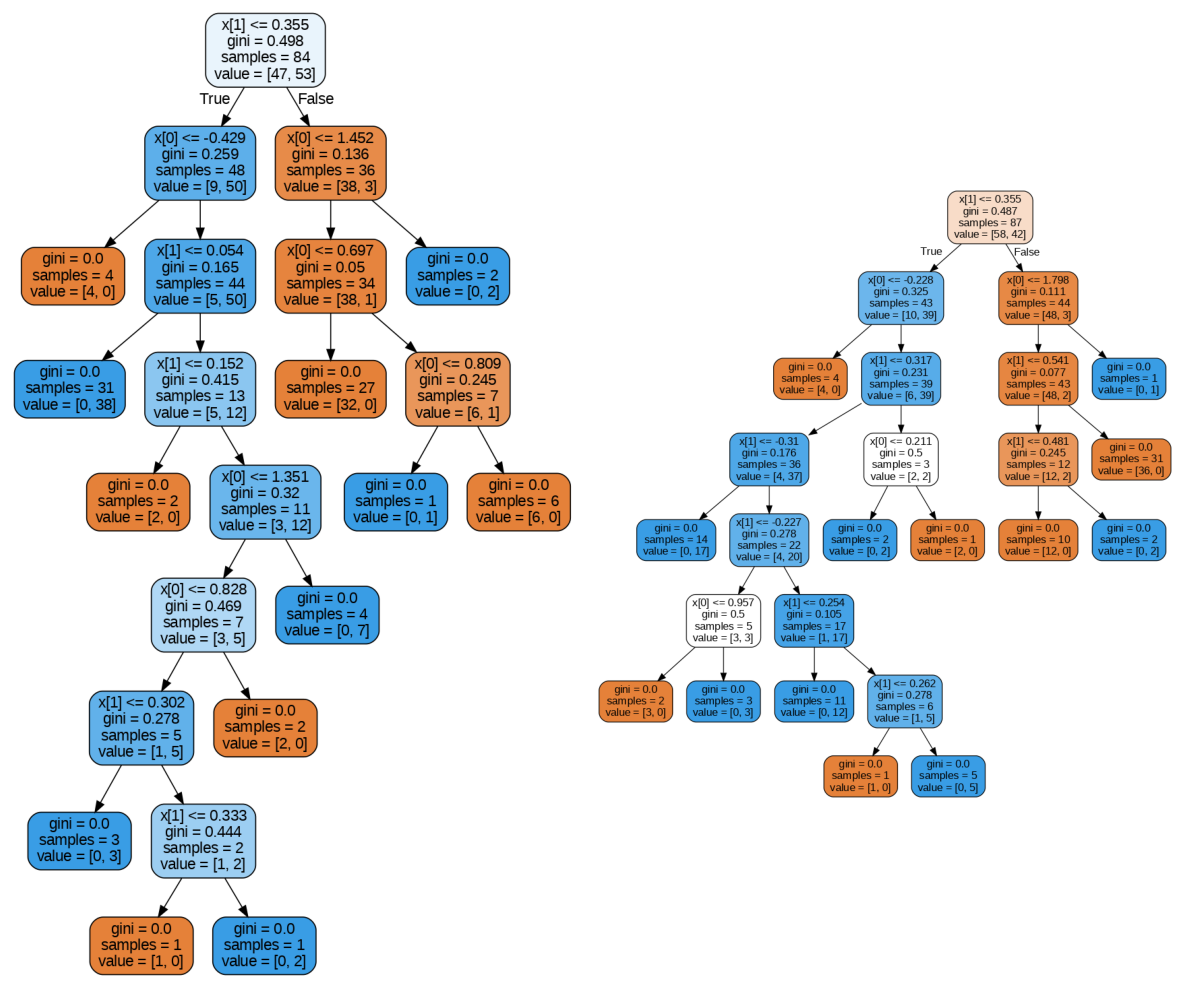

In [7]:
img_path1 = create_and_save_dot_image(bag_clf.estimators_[0], '15,15!', 'tree1')
img_path2 = create_and_save_dot_image(bag_clf.estimators_[1], '10,10!', 'tree2')

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

img1 = Image(filename=img_path1)
axes[0].imshow(plt.imread(img_path1))
axes[0].axis('off')

img2 = Image(filename=img_path2)
axes[1].imshow(plt.imread(img_path2))
axes[1].axis('off')

plt.tight_layout()
plt.show()

The tree structures are totally difference and this is because they use difference subsets for fitting. It is evident that how a single decision tree classifier is sensitive to the training instances.

Let's compare the the out-of-bag evaluation score with evaluation score of the model. The former is computed on the remaing 37% of the unsampled instances in the training set, and the latter is computed on the test set.

In [8]:
print(f"Out-of-bag score: {bag_clf.oob_score_:.3f}")
print(f"Test score: {bag_clf.score(X_test, y_test)}")

Out-of-bag score: 0.925
Test score: 0.904


In [9]:
# Another method to compute the score
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


It seems the OOB score is a bit optimistic.

In [10]:
bag_clf.oob_decision_function_[:3]

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ]])

In [11]:
X_train[:3]

array([[ 1.53869929,  0.18874413],
       [ 0.39469854,  0.32372361],
       [-0.91914656,  1.31188165]])

Note that because the base estimator (_DecisionTreeClassifier_) does not have `.decision_function` attribute, I can use that to get the average score of all 500 base estimators.

## Plot Decision Boundaries

Let's plot the first two tree's decision boundary and comapre them to the decision bondary of the bagging classifier.

In [100]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#F9F7F7', '#3F72AF'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # field
    ax.contour(x1, x2, y_pred, cmap="crest", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels, s=50, alpha=0.3):
    for i in range(len(styles)):
        sns.scatterplot(x=X[:, 0][y == i], y=X[:, 1][y == i], ax=ax, marker=styles[i][0], color=styles[i][1], s=s, edgecolor='k', alpha=alpha)

    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

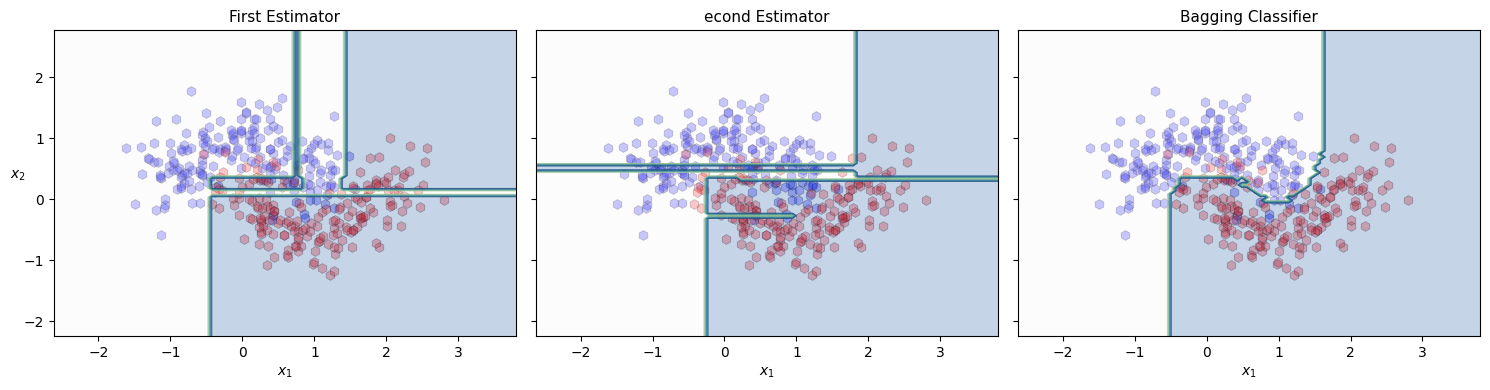

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf.estimators_[0], X_train, y_train, axes[0])
axes[0].set_title("First Estimator", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf.estimators_[1], X_train, y_train, axes[1])
axes[1].set_title("econd Estimator", fontsize=11)

plot_points(X_train, y_train, axes[2], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf, X_train, y_train, axes[2])
axes[2].set_title("Bagging Classifier", fontsize=11)

plt.tight_layout()
plt.show()

The two individual estimators seems to have higher variance comapred to the bagging classifier. I can check how the overall score of the bagging classifier has been improved compared to the its estimators.

In [15]:
print(f"First Estimator's score: {bag_clf.estimators_[0].score(X_test, y_test)}")
print(f"Second Estimator's score: {bag_clf.estimators_[1].score(X_test, y_test)}")
print(f"Bagging Classifier's score: {bag_clf.score(X_test, y_test)}")

First Estimator's score: 0.856
Second Estimator's score: 0.84
Bagging Classifier's score: 0.904


Let me check the bias and variance of the the bagging classifier to its estimators.

In [ ]:
bag_scores = cross_val_score(bag_clf, X_train, y_train, cv=10, scoring='accuracy')
first_est_scores = cross_val_score(bag_clf.estimators_[0], X_train, y_train, cv=10, scoring='accuracy')
second_est_scores = cross_val_score(bag_clf.estimators_[1], X_train, y_train, cv=10, scoring='accuracy')

In [23]:
print(f"Bagging Classifier's bias: {np.mean(bag_scores):.3f}")
print(f"Bagging Classifier's variance: {np.var(bag_scores):.5f}\n")

print(f"First Estimator's bias: {np.mean(first_est_scores):.3f}")
print(f"First Estimator's variance: {np.var(first_est_scores):.5f}\n")

print(f"Second Estimator's bias: {np.mean(second_est_scores):.3f}")
print(f"Second Estimator's variance: {np.var(second_est_scores):.5f}")

Bagging Classifier's bias: 0.928
Bagging Classifier's variance: 0.00059

First Estimator's bias: 0.864
First Estimator's variance: 0.00315

Second Estimator's bias: 0.864
Second Estimator's variance: 0.00317


Bias of the bagging classfier is sligtly higher than it estimators (about 7%). However, it variance is dramatically reduce (about 81%). This means that the bagging decisiob boundary will likely generalize much better that its estimators.

## Pasting Classifier
Pasting classifier use sampling without replacement. I need to set the `bootstrp=False` to specify that I want to use sampling without replacement.<br>

When using BaggingClassifier with bootstrap=False (sampling without replacement), each base estimator is trained on a unique subset of the training data. If **n_estimators × max_samples** exceeds the total number of available samples, it means that there aren't enough unique samples to satisfy the requirement for all estimators.<br>

In this scenario, some estimators will end up being trained on overlapping subsets of the training data. This can reduce the diversity among the base estimators, potentially diminishing the benefits of the ensemble method, such as variance reduction12.<br>

To avoid this, i increase the number of samples, and re-train the `bag_clf` on the new training set.

In [104]:
# Create dataset
X, y = make_moons(n_samples=3500, noise=0.3, random_state=42)

# Split dataset to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Default test size 25% of X

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2625, 2)
y_train shape: (2625,)

X_test shape: (875, 2)
y_test shape: (875,)


Total number of training sample (2625) exceeds the n_estimators × max_samples (50 × 50 = 2500). So there will be not be any overlappings when I use pasting classifier.

In [105]:
# Baggin classifier (sampling with replacement)
bag_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=50,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=50, n_estimators=50, n_jobs=-1, oob_score=True,
                  random_state=42)

In [106]:
# Pasting classifier (sampling without replacement)
pasting_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=50,
    bootstrap=False,
    n_jobs=-1,
    random_state=42)

pasting_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=50, n_estimators=50, n_jobs=-1, random_state=42)

In [84]:
print(f"Bagging classifier's score: {bag_clf.score(X_test, y_test):.3f}")
print(f"Pasting classifier's score: {pasting_clf.score(X_test, y_test):.3f}")

Bagging classifier's score: 0.875
Pasting classifier's score: 0.889


The pasting classifier achieved a slightly higher score thant the bagging classifier.

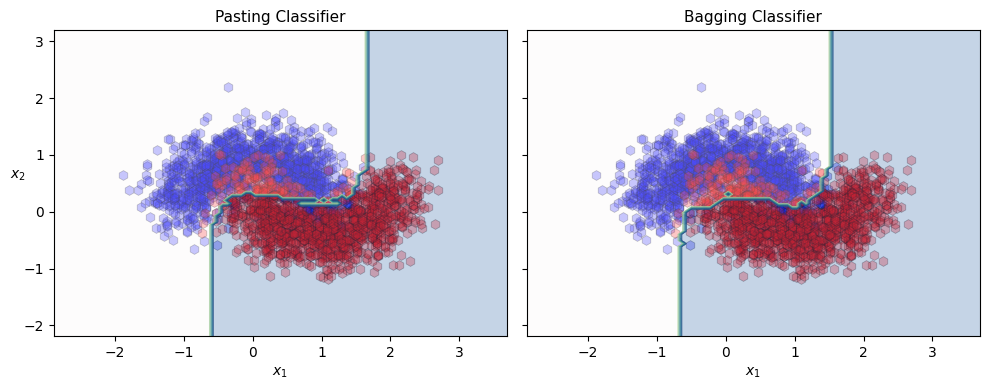

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(pasting_clf, X_train, y_train, axes[0])
axes[0].set_title("Pasting Classifier", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf, X_train, y_train, axes[1])
axes[1].set_title("Bagging Classifier", fontsize=11)

plt.tight_layout()
plt.show()

The pasting decision boundary seems to have a bit higher varience (overfitted) on the training set. Let's check the bias and variance of the two classifiers.

In [77]:
bag_scores = cross_val_score(bag_clf, X_train, y_train, cv=10, scoring='accuracy')
pasting_scores = cross_val_score(pasting_clf, X_train, y_train, cv=10, scoring='accuracy')

In [78]:
print(f"Bagging Classifier's bias: {np.mean(bag_scores):.3f}")
print(f"Bagging Classifier's variance: {np.var(bag_scores):.5f}\n")

print(f"Pasting Classifier's bias: {np.mean(pasting_scores):.3f}")
print(f"Pasting Classifier's variance: {np.var(pasting_scores):.5f}")

Bagging Classifier's bias: 0.861
Bagging Classifier's variance: 0.00287

Pasting Classifier's bias: 0.872
Pasting Classifier's variance: 0.00260


Pasting seems to have higher bias and lower variance than the bagging. It seems to be the opposite of what is expected. I think it attributed to training these models on such a small trainig sets. Let's increase the training set, n_estimators, and max_samples and compare the results again.

In [108]:
X, y = make_moons(n_samples=70_000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [109]:
# Baggin classifier (sampling with replacement)
bag_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

In [110]:
# Pasting classifier (sampling without replacement)
pasting_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=False,
    n_jobs=-1,
    random_state=42)

pasting_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=42)

In [89]:
bag_scores = cross_val_score(bag_clf, X_train, y_train, cv=10, scoring='accuracy')
pasting_scores = cross_val_score(pasting_clf, X_train, y_train, cv=10, scoring='accuracy')

In [90]:
print(f"Bagging Classifier's bias: {np.mean(bag_scores):.3f}")
print(f"Bagging Classifier's variance: {np.var(bag_scores):.5f}\n")

print(f"Pasting Classifier's bias: {np.mean(pasting_scores):.3f}")
print(f"Pasting Classifier's variance: {np.var(pasting_scores):.5f}")

Bagging Classifier's bias: 0.910
Bagging Classifier's variance: 0.00003

Pasting Classifier's bias: 0.910
Pasting Classifier's variance: 0.00003


It seems the data set is sufficiently large that both classifiers achieved almost the same level of bias and variance.

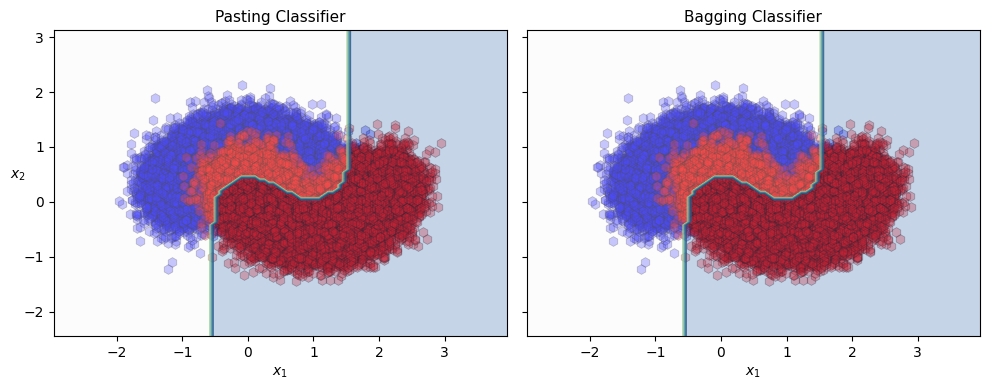

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(pasting_clf, X_train, y_train, axes[0])
axes[0].set_title("Pasting Classifier", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(bag_clf, X_train, y_train, axes[1])
axes[1].set_title("Bagging Classifier", fontsize=11)

plt.tight_layout()
plt.show()